# Generate synthetic lightcurves
Sample from parameters of all 78 Gaussian Processes to generate synthetic lightcurves.


Add uncorrelated noise by:
   - Fit GP to each lightcurve
   - Define distribution over GP parameters
   - Create histogram of residuals (how many of each amplitude)
   - Define cutoff as 3 sigma
   - Add all cutoff 'tails' to create an 'average' noise distribution

In [136]:
# imports
import numpy as np
import csv
import matplotlib.pyplot as plt
from astropy.io import fits
import torch
import gpytorch
import matplotlib.pyplot as plt

from dipper.data_utils.utils import *
from dipper.model_utils.gp_model import train_gp, QuasiPeriodicKernel
from scipy.stats import lognorm
from sklearn.mixture import GaussianMixture
from gpytorch.means import ConstantMean
from gpytorch.kernels import Kernel, PeriodicKernel, RBFKernel, ScaleKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.constraints import Interval, Positive, GreaterThan

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Single lightcurve

Dominant period: 7.998106060606061


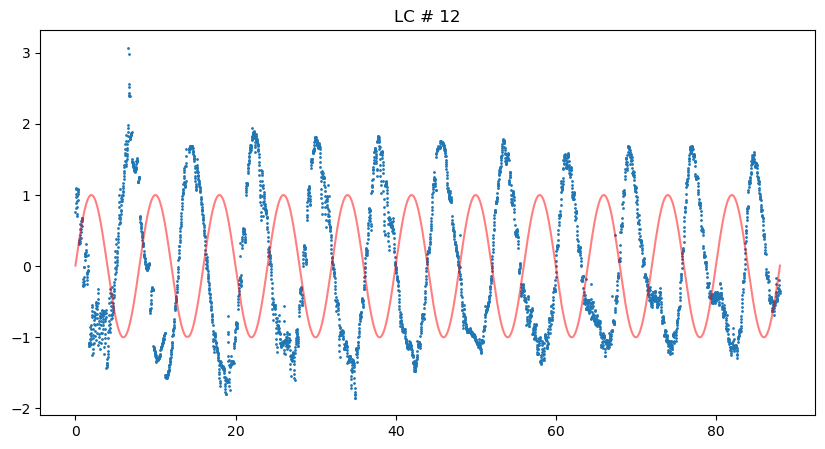

In [211]:
# Load the data
file_number = 12
data_dir = '../../data/k2/'
filename = f'k2_{file_number}.fits'
x, y, y_err = load_k2_data(data_dir + filename)

# Scale data to be between 0 and 1
y = (y - np.min(y)) / (np.max(y) - np.min(y))
y_err = y_err / (np.max(y) - np.min(y))

# Standardize data to have mean 0 and std of 1
mean_y = np.mean(y)
std_y = np.std(y)
y = (y - mean_y) / std_y
y_err = y_err / std_y

# Find period of the light curve and convert from index to days (what x is in)
period = get_dom_period(y)
period = period * (x[-1] - x[0]) / len(x)
print(f"Dominant period: {period}")
sinusoid = np.sin(2 * np.pi * x / period)

# Plot anomalies
plt.figure(figsize=(10,5))
plt.plot(x, y, '.', markersize=2)
plt.plot(x, sinusoid, 'r', alpha=0.5)
plt.title(f"LC # {file_number}")
plt.show()

In [ ]:
# TODO: Realizing that multiplying the two components may not be the correct implementation of the quasi-periodic kernel
class QuasiPeriodicKernel(Kernel):
    def __init__(self, **kwargs):
        super(QuasiPeriodicKernel, self).__init__(**kwargs)
        self.periodic_kernel = PeriodicKernel(**kwargs)
        self.rbf_kernel = RBFKernel(**kwargs)
        # self.raw_rbf_weight = torch.nn.Parameter(torch.tensor(0.5))
        # self.raw_periodic_weight = torch.nn.Parameter(torch.tensor(0.5))
        # self.register_constraint("raw_rbf_weight", Interval(0.0, 1.0))
        # self.register_constraint("raw_periodic_weight", Interval(0.0, 1.0))

    # @property
    # def rbf_weight(self):
    #     return self.raw_rbf_weight_constraint.transform(self.raw_rbf_weight)

    # @property
    # def periodic_weight(self):
    #     return self.raw_periodic_weight_constraint.transform(self.raw_periodic_weight)

    def forward(self, x1, x2, diag=False, **params):
        # rbf_weight = self.rbf_weight / (self.rbf_weight + self.periodic_weight)
        # periodic_weight = self.periodic_weight / (self.rbf_weight + self.periodic_weight)
        periodic_part = self.periodic_kernel.forward(x1, x2, diag=diag, **params) #* periodic_weight
        rbf_part = self.rbf_kernel.forward(x1, x2, diag=diag, **params) #* rbf_weight
        return periodic_part * rbf_part

# Define GP model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = ScaleKernel(kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

# Function to train GP model
def train_gp(
        x_train, 
        y_train, 
        y_err_train, 
        training_iterations=50, 
        lr=0.1,
        learn_additional_noise=True, 
        device=torch.device("cpu"), 
        kernel=None
    ):
    # Create noisy likelihood
    noise_variances = y_err_train ** 2
    likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(
        noise=noise_variances, 
        learn_additional_noise=learn_additional_noise
    ).to(device) # If this gives numerical warnings, use GaussianLikelihood() instead of FixedNoiseGaussianLikelihood()

    # Initialize model
    if kernel is not None:
        model = ExactGPModel(
            x_train, 
            y_train, 
            likelihood, 
            kernel,
        ).to(device)

    else:
        print("No kernel specified. Using Quasi-Periodic Kernel with no priors or constraints.")
        model = ExactGPModel(
            x_train, 
            y_train, 
            likelihood,
            QuasiPeriodicKernel()
        ).to(device)

    # Find optimal hyperparameters
    model.train()
    likelihood.train()

    # Set optimizer and loss
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    # Plot loss during training
    losses = []
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(x_train)
        loss = -mll(output, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    # Plot the loss
    plt.figure(figsize=(10,5))
    plt.plot(range(training_iterations), losses)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.show()

    return model, likelihood, mll

Fit GP and get model parameters

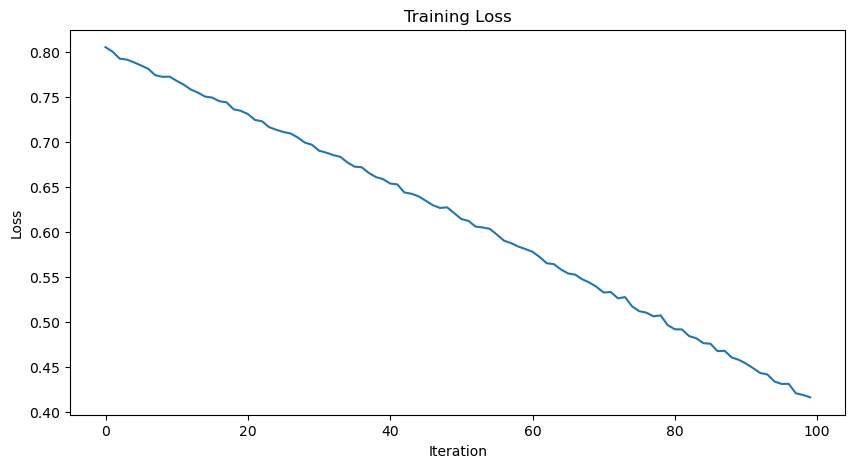

In [217]:
# Remove data between x = 30 and x = 50
x_new = x[(x < 30) | (x > 40)]
y_new = y[(x < 30) | (x > 40)]
y_err_new = y_err[(x < 30) | (x > 40)]

# Hyperparameters
training_iterations = 100
lr = 0.01
learn_additional_noise = True
# kernel = PeriodicKernel(
#     period_length_constraint=Positive(initial_value=period)
# )
# kernel = RBFKernel(
# lengthscale_constraint=Positive(initial_value=0.7)
# )
kernel = QuasiPeriodicKernel(
    period_length_constraint=Positive(initial_value=period), 
    lengthscale_constraint=Positive(initial_value=1.0)
)

# Train GP model
model, likelihood, mll = train_gp(
    torch.tensor(x_new, dtype=torch.float32).to(device),
    torch.tensor(y_new, dtype=torch.float32).to(device), 
    torch.tensor(y_err_new, dtype=torch.float32).to(device), 
    training_iterations=training_iterations, 
    lr=lr,
    device=device,
    learn_additional_noise=learn_additional_noise,
    kernel=kernel
)

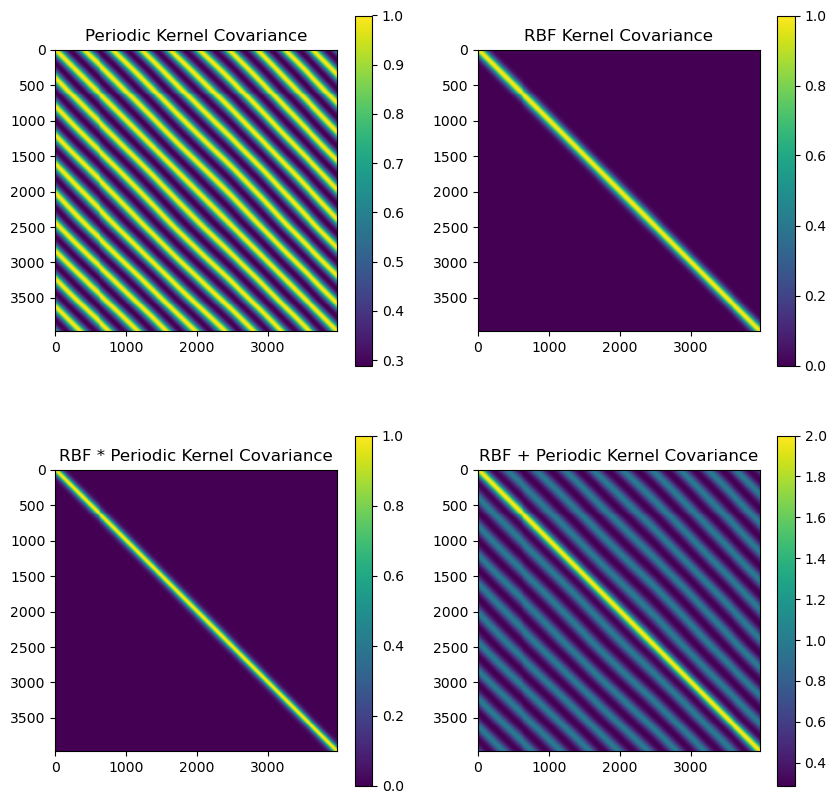

In [221]:
with torch.no_grad():
    periodic_cov = model.covar_module.base_kernel.periodic_kernel(torch.tensor(x).to(device)).evaluate()
    rbf_cov = model.covar_module.base_kernel.rbf_kernel(torch.tensor(x).to(device)).evaluate()

    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 1)
    plt.title("Periodic Kernel Covariance")
    plt.imshow(periodic_cov.cpu().numpy(), cmap='viridis')
    plt.colorbar()

    plt.subplot(2, 2, 2)
    plt.title("RBF Kernel Covariance")
    plt.imshow(rbf_cov.cpu().numpy(), cmap='viridis')
    plt.colorbar()

    plt.subplot(2, 2, 3)
    plt.title("RBF * Periodic Kernel Covariance")
    plt.imshow(rbf_cov.cpu().numpy() * periodic_cov.cpu().numpy(), cmap='viridis')
    plt.colorbar()

    plt.subplot(2, 2, 4)
    plt.title("RBF + Periodic Kernel Covariance")
    plt.imshow(rbf_cov.cpu().numpy() + periodic_cov.cpu().numpy(), cmap='viridis')
    plt.colorbar()

likelihood.second_noise_covar.raw_noise: -1.0261527299880981
mean_module.raw_constant: 0.01995312049984932
covar_module.raw_outputscale: 0.08584423363208771
covar_module.base_kernel.periodic_kernel.raw_lengthscale: 1.3889011144638062
covar_module.base_kernel.periodic_kernel.raw_period_length: 8.892090797424316
covar_module.base_kernel.rbf_kernel.raw_lengthscale: 1.3227214813232422

Learned GP parameters:
Mean Constant:  0.01995312049984932
Outputscale:  0.7369901537895203
Additional Noise:  [0.30649507 0.30649507 0.30649507 ... 0.30649507 0.30649507 0.30649507]
Periodic Lengthscale:  1.6115238666534424
Period Length:  8.892228126525879
RBF Lengthscale:  1.5589070320129395


Text(0.5, 1.0, 'LC # 12')

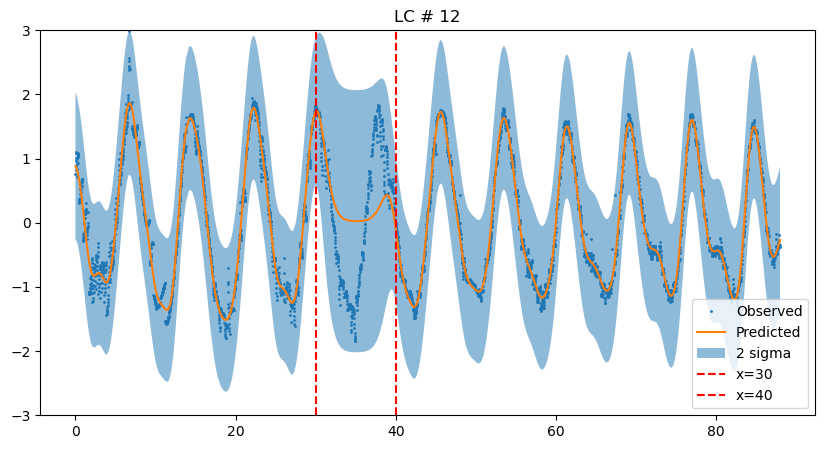

In [219]:
# Print learned GP parameters
for name, param in model.named_parameters():
    print(f"{name}: {param.data.item()}")

noises = model.likelihood.noise.squeeze().detach().cpu().numpy()
outputscale = model.covar_module.outputscale.item()
mean_constant = model.mean_module.constant.item()

print("\nLearned GP parameters:")
print("Mean Constant: ", mean_constant)
print("Outputscale: ", outputscale)
print("Additional Noise: ", noises)

if isinstance(kernel, QuasiPeriodicKernel):
    period_length = model.covar_module.base_kernel.periodic_kernel.period_length.item()
    periodic_lengthscale = model.covar_module.base_kernel.periodic_kernel.lengthscale.item()
    lengthscale = model.covar_module.base_kernel.rbf_kernel.lengthscale.item()

    # print("Periodic weight: ", model.covar_module.base_kernel.periodic_weight.item())
    # print("RBF weight: ", model.covar_module.base_kernel.rbf_weight.item())
    print("Periodic Lengthscale: ", periodic_lengthscale)
    print("Period Length: ", period_length)
    print("RBF Lengthscale: ", lengthscale)

elif isinstance(kernel, RBFKernel):
    lengthscale = model.covar_module.base_kernel.lengthscale.item()
    print("RBF Lengthscale: ", lengthscale)

elif isinstance(kernel, PeriodicKernel):
    period_length = model.covar_module.base_kernel.period_length.item()
    periodic_lengthscale = model.covar_module.base_kernel.lengthscale.item()

    print("Period Length: ", period_length)
    print("Periodic Lengthscale: ", periodic_lengthscale)

# Predict
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(torch.tensor(x, dtype=torch.float32).to(device)))
    samples = predictions.sample(sample_shape=torch.Size([3]))
    mean = predictions.mean.cpu().numpy()
    variance = predictions.variance.cpu().numpy()
    stddev = np.sqrt(variance)

# Plot
plt.figure(figsize=(10,5))
plt.plot(x, y, '.', markersize=2, label='Observed')
plt.plot(x, mean, label='Predicted')
plt.fill_between(x, mean - 2*stddev, mean + 2*stddev, alpha=0.5, label='2 sigma')
plt.axvline(30, color='r', linestyle='--', label=f'x=30')
plt.axvline(40, color='r', linestyle='--', label=f'x=40')
plt.ylim(-3, 3)
plt.legend()
plt.title(f"LC # {file_number}")

# plt.figure(figsize=(10,5))
# plt.plot(x, y, '.', markersize=2, label='Observed')
# plt.plot(x, mean, label='Predicted')
# plt.xlim(0, 10)
# plt.ylim(-3, 3)
# plt.legend()
# plt.title(f"LC # {file_number}")
# plt.show()

# plt.figure(figsize=(10,5))
# plt.plot(x, y, '.', markersize=2, label='Observed')
# for i in range(3):
#     plt.plot(x, samples[i].cpu().numpy(), alpha=0.5, label='Sample')
# plt.ylim(-3, 3)
# plt.legend()
# plt.title(f"LC # {file_number}")
# plt.show()

Number of high residuals: 0 with values [] and x values []
cutoff_mean: 1.1622222661972046


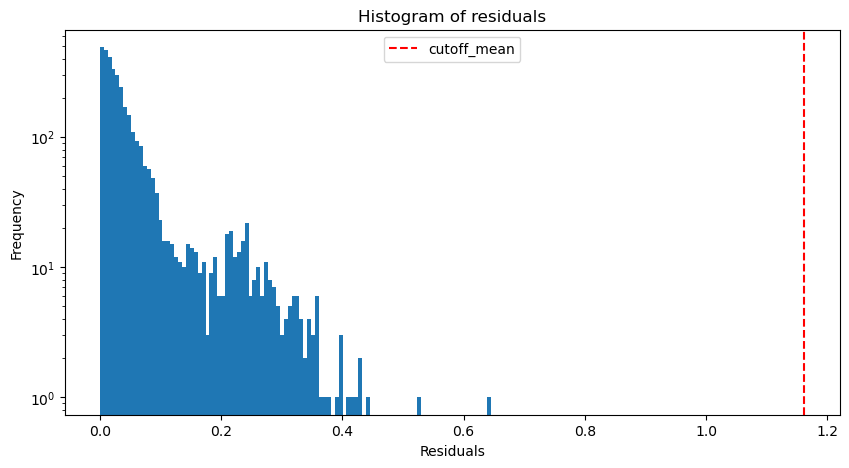

In [210]:
# Calculate residuals
residuals = np.abs((mean - y))
cutoff = 2*stddev
cutoff_mean = 2*np.mean(stddev)
high_residuals = residuals[residuals > cutoff]
print(f"Number of high residuals: {len(high_residuals)} with values {high_residuals} and x values {x[residuals > cutoff]}")
print(f"cutoff_mean: {cutoff_mean}")

# Plot histogram of residuals
plt.figure(figsize=(10,5))
plt.hist(residuals, bins=100)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.yscale('log')
plt.title("Histogram of residuals")
plt.axvline(x=cutoff_mean, color='r', linestyle='--', label=f'cutoff_mean')
plt.legend()
plt.show()

## Create distribution over all 78 lightcurves

### Create list of GP learned parameters and high_residuals for each lightcurve

In [23]:
# Initialize lists
mean_constants = []
outputscales = []
periodic_lengthscales = []
period_lengths = []
rbf_lengthscales = []
noises = []
high_residuals = []

# Hyperparameters
initial_lengthscale = 0.7
training_iterations = 50
learn_additional_noise = True

# Load each file, train GP, append values to lists of GP parameters and tail distribution
for file_number in range(78):
    # Load the data
    data_dir = '../../data/k2/'
    filename = f'k2_{file_number}.fits'
    x, y, y_err = load_k2_data(data_dir + filename)

    # Scale data to be between 0 and 1
    y = (y - np.min(y)) / (np.max(y) - np.min(y))
    y_err = y_err / (np.max(y) - np.min(y))

    # Standardize data to have mean 0 and std of 1
    mean_y = np.mean(y)
    std_y = np.std(y)
    y = (y - mean_y) / std_y
    y_err = y_err / std_y
    
    # Train GP model
    model, likelihood, mll = train_gp(
        torch.tensor(x, dtype=torch.float32).to(device),
        torch.tensor(y, dtype=torch.float32).to(device), 
        torch.tensor(y_err, dtype=torch.float32).to(device), 
        training_iterations=training_iterations, 
        lengthscale=initial_lengthscale, 
        device=device,
        learn_additional_noise=learn_additional_noise
    )

    # Evaluate model and append high residuals to list
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        predictions = likelihood(model(torch.tensor(x, dtype=torch.float32).to(device)))
        mean = predictions.mean.cpu().numpy()
        variance = predictions.variance.cpu().numpy()
        stddev = np.sqrt(variance)

    residuals = np.abs((mean - y))
    curr_high_residuals = residuals[residuals > 3*stddev]
    high_residuals.extend(curr_high_residuals)

    # Append GP parameters to lists
    mean_constants.append(model.mean_module.constant.item())
    outputscales.append(model.covar_module.outputscale.item())
    periodic_lengthscales.append(model.covar_module.base_kernel.periodic_kernel.lengthscale.item())
    period_lengths.append(model.covar_module.base_kernel.periodic_kernel.period_length.item())
    rbf_lengthscales.append(model.covar_module.base_kernel.rbf_kernel.lengthscale.item())
    noises.append(np.mean(model.likelihood.noise.squeeze().detach().cpu().numpy()))

78 78 78 78 78 78 156
3.105996644029492 50.50047205048378


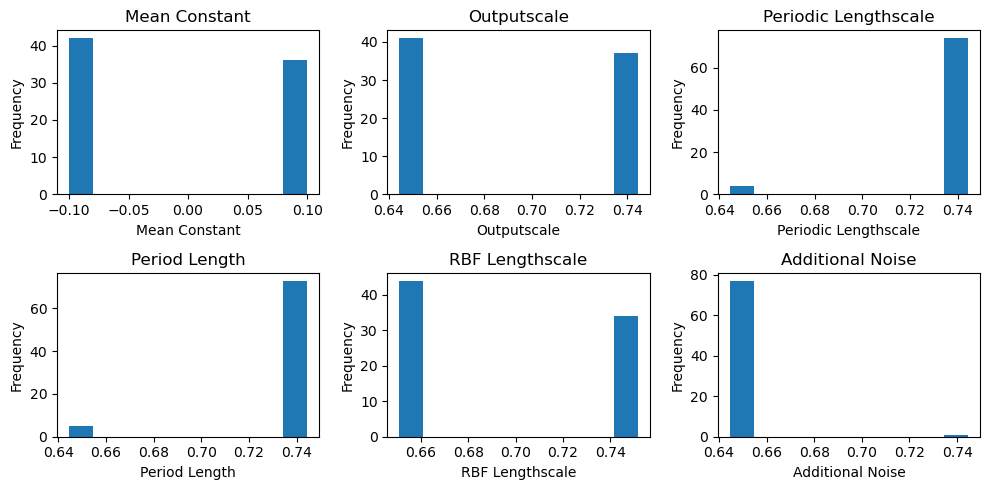

Text(0.5, 1.0, 'High Residuals')

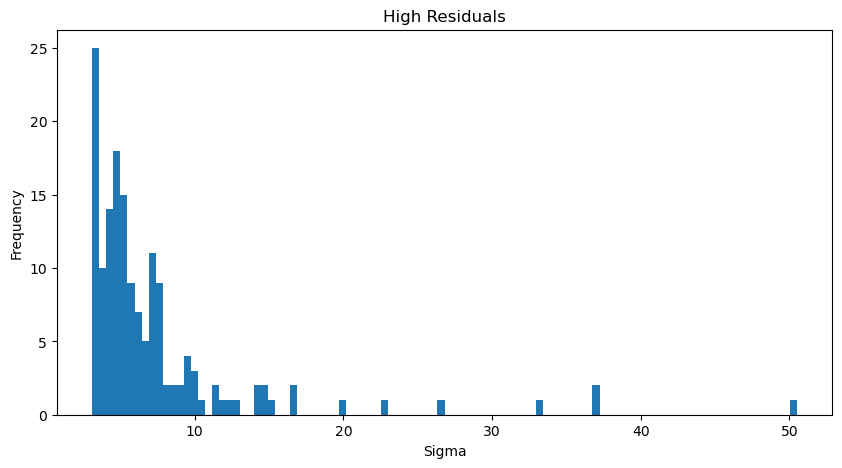

In [24]:
# Check all lists have the same length
print(len(mean_constants), len(outputscales), len(periodic_lengthscales), len(period_lengths), len(rbf_lengthscales), len(noises), len(high_residuals))
print(min(high_residuals), max(high_residuals))

# Plot parameters all in one plot, separate subplots for each parameter
plt.figure(figsize=(10,5))
plt.subplot(2,3,1)
plt.hist(mean_constants, bins=10)
plt.xlabel("Mean Constant")
plt.ylabel("Frequency")
plt.title("Mean Constant")

plt.subplot(2,3,2)
plt.hist(outputscales, bins=10)
plt.xlabel("Outputscale")
plt.ylabel("Frequency")
plt.title("Outputscale")

plt.subplot(2,3,3)
plt.hist(periodic_lengthscales, bins=10)
plt.xlabel("Periodic Lengthscale")
plt.ylabel("Frequency")
plt.title("Periodic Lengthscale")

plt.subplot(2,3,4)
plt.hist(period_lengths, bins=10)
plt.xlabel("Period Length")
plt.ylabel("Frequency")
plt.title("Period Length")

plt.subplot(2,3,5)
plt.hist(rbf_lengthscales, bins=10)
plt.xlabel("RBF Lengthscale")
plt.ylabel("Frequency")
plt.title("RBF Lengthscale")

plt.subplot(2,3,6)
plt.hist(noises, bins=10)
plt.xlabel("Additional Noise")
plt.ylabel("Frequency")
plt.title("Additional Noise")

plt.tight_layout()
plt.show()

# Plot histogram of high residuals
plt.figure(figsize=(10,5))
plt.hist(high_residuals, bins=100)
plt.xlabel("Sigma")
plt.ylabel("Frequency")
plt.title("High Residuals")

Bimodal gaussian distribution for the 6 parameters of the GP, and skewed/not bimodal distribution for the high_residuals (log-normal)

In [25]:
# # Write GP parameters and high_residuals to file in data folder as a csv with column names
# with open('../../data/gp_parameters.csv', mode='w') as file:
#     writer = csv.writer(file)
#     writer.writerow(['file_number', 'mean_constant', 'outputscale', 'periodic_lengthscale', 'period_length', 'rbf_lengthscale', 'noise'])
#     for i in range(len(mean_constants)):
#         writer.writerow([i, mean_constants[i], outputscales[i], periodic_lengthscales[i], period_lengths[i], rbf_lengthscales[i], noises[i]])

# with open('../../data/high_residuals.csv', mode='w') as file:
#     writer = csv.writer(file)
#     writer.writerow(['high_residual'])
#     for i in range(len(high_residuals)):
#         writer.writerow([high_residuals[i]])

### Read parameters and generate a sample from distribution over parameters

In [26]:
# Read GP parameters and high_residuals from files
mean_constants = []
outputscales = []
periodic_lengthscales = []
period_lengths = []
rbf_lengthscales = []
noises = []
high_residuals = []

with open('../../data/gp_parameters.csv', mode='r') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        mean_constants.append(float(row[1]))
        outputscales.append(float(row[2]))
        periodic_lengthscales.append(float(row[3]))
        period_lengths.append(float(row[4]))
        rbf_lengthscales.append(float(row[5]))
        noises.append(float(row[6]))

with open('../../data/high_residuals.csv', mode='r') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        high_residuals.append(float(row[0]))

print(len(mean_constants), len(outputscales), len(periodic_lengthscales), len(period_lengths), len(rbf_lengthscales), len(noises), len(high_residuals))

78 78 78 78 78 78 156


In [38]:
# Function to fit GMM to data
def fit_gmm(data, n_components=2):
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(np.array(data).reshape(-1, 1))
    return gmm

# Fit GMMs for bimodal distributions
mean_constant_gmm = fit_gmm(mean_constants)
outputscale_gmm = fit_gmm(outputscales)
periodic_lengthscale_gmm = fit_gmm(periodic_lengthscales)
period_length_gmm = fit_gmm(period_lengths)
rbf_lengthscale_gmm = fit_gmm(rbf_lengthscales)
noise_gmm = fit_gmm(noises)

# Fit log-normal for high residuals
shape, loc, scale = lognorm.fit(high_residuals, floc=0)

# Function to sample from distributions
def sample_parameters():
    sample_mean_constant = mean_constant_gmm.sample(1)[0][0][0]
    sample_outputscale = outputscale_gmm.sample(1)[0][0][0]
    sample_periodic_lengthscale = periodic_lengthscale_gmm.sample(1)[0][0][0]
    sample_period_length = period_length_gmm.sample(1)[0][0][0]
    sample_rbf_lengthscale = rbf_lengthscale_gmm.sample(1)[0][0][0]
    sample_noise = noise_gmm.sample(1)[0][0][0]

    # Generate a random number of high residuals (between 1-5)
    num_high_residuals = np.random.randint(1, 6)
    sample_high_residuals = lognorm.rvs(shape, loc, scale, size=num_high_residuals).tolist()
    # Randomly have some be negative residuals
    for i in range(num_high_residuals):
        if np.random.rand() < 0.3:
            sample_high_residuals[i] = -sample_high_residuals[i]

    return {
        "mean_constant": sample_mean_constant,
        "outputscale": sample_outputscale,
        "periodic_lengthscale": sample_periodic_lengthscale,
        "period_length": sample_period_length,
        "rbf_lengthscale": sample_rbf_lengthscale,
        "noise": sample_noise,
        "high_residuals": sample_high_residuals
    }

# Example usage
random_sample = sample_parameters()
print(random_sample)

{'mean_constant': -0.10110660389713291, 'outputscale': 0.6432849866174289, 'periodic_lengthscale': 0.743284767243314, 'period_length': 0.743284744374158, 'rbf_lengthscale': 0.649796412576255, 'noise': 0.6434848127350349, 'high_residuals': [-5.741924579167374]}


In [ ]:
# TODO: change to using model.initialize() at https://docs.gpytorch.ai/en/latest/examples/00_Basic_Usage/Hyperparameters.html
class ParameterizedQuasiPeriodicKernel(Kernel):
    def __init__(self, period_length, periodic_lengthscale, rbf_lengthscale):
        super().__init__()
        self.periodic_kernel = PeriodicKernel()
        self.periodic_kernel.period_length = period_length
        self.periodic_kernel.lengthscale = periodic_lengthscale

        self.rbf_kernel = RBFKernel()
        self.rbf_kernel.lengthscale = rbf_lengthscale

    def forward(self, x1, x2, diag=False, **params):
        periodic_part = self.periodic_kernel.forward(x1, x2, diag=diag, **params)
        rbf_part = self.rbf_kernel.forward(x1, x2, diag=diag, **params)
        return periodic_part * rbf_part

class ParameterizedGPModel(gpytorch.models.GP):
    def __init__(self, mean_constant, outputscale, noise_vars, period_length, periodic_lengthscale, rbf_lengthscale):
        super().__init__()
        self.mean_module = gpytorch.means.ConstantMean()
        self.mean_module.constant = mean_constant

        kernel = ParameterizedQuasiPeriodicKernel(period_length, periodic_lengthscale, rbf_lengthscale)
        
        self.covar_module = ScaleKernel(kernel)
        self.covar_module.outputscale = outputscale

        self.likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise_vars)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [40]:
def generate_synthetic_lc_sample(
    num_timesteps=3000,
    num_samples=1,
    device="cpu",
    ):
    # Sample GP parameters
    params = sample_parameters()
    period_length = torch.tensor(params["period_length"]).to(device)
    periodic_lengthscale = torch.tensor(params["periodic_lengthscale"]).to(device)
    rbf_lengthscale = torch.tensor(params["rbf_lengthscale"]).to(device)
    outputscale = torch.tensor(params["outputscale"]).to(device)
    mean_constant = torch.tensor(params["mean_constant"]).to(device)

    # Define timesteps and noise
    x = torch.linspace(0, 10, num_timesteps).to(device)
    noise_vars = torch.tensor([params["noise"]] * num_timesteps).to(device)

    # Get GP model
    model = ParameterizedGPModel(mean_constant, outputscale, noise_vars, period_length, periodic_lengthscale, rbf_lengthscale).to(device)

    # Generate predictions
    model.eval()
    model.likelihood.eval()

    with torch.no_grad():
        # Generate the GP predictions
        predictions = model.likelihood(model(x))
        samples = predictions.sample(torch.Size([num_samples]))

    # Convert to numpy for further processing
    x = x.detach().cpu().numpy()
    samples = samples.detach().cpu().numpy()
    for i in range(num_samples):
        # Add some high residuals randomly distributed
        num_high_residuals = len(params["high_residuals"])
        high_residual_indices = np.random.choice(num_timesteps, num_high_residuals, replace=False)
        for j, idx in enumerate(high_residual_indices):
            samples[i, idx] += params["high_residuals"][j]

    return x, samples

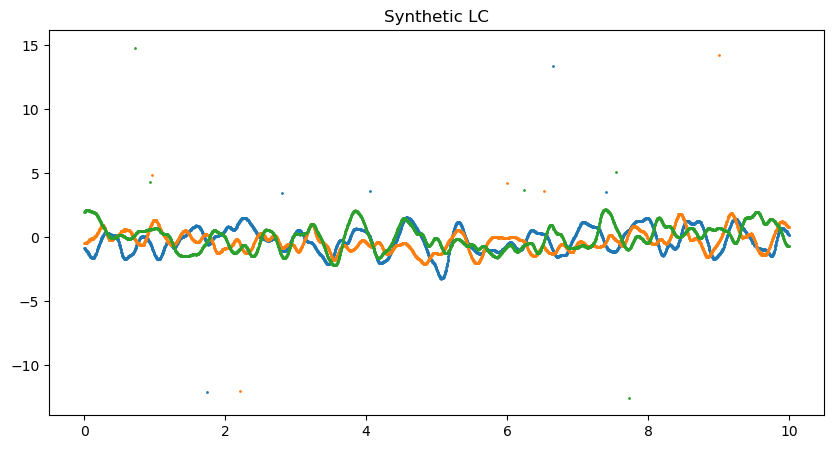

In [41]:
# Generate synthetic LC sample
time_steps = 3000
num_samples = 3
x, ys = generate_synthetic_lc_sample(time_steps, num_samples, device)

plt.figure(figsize=(10,5))
for i in range(num_samples):
    plt.plot(x, ys[i], '.', markersize=2)
plt.title("Synthetic LC")
plt.show()